In [1]:
from __future__ import division
from __future__ import print_function
%matplotlib inline
import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, SubsetRandomSampler

from utils import load_data_card
from models import GAT_base

In [2]:
def createSampler(dataset):
    dataset_size = len(dataset)
    dataset_indices = list(range(dataset_size))
    np.random.shuffle(dataset_indices)
    split_index = int(np.floor(dataset_size))
    idx = dataset_indices[:split_index]
    return SubsetRandomSampler(idx)

def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
adj, train_dataset, test_dataset, valid_dataset, classes = load_data_card()
# Model and optimizer

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=createSampler(train_dataset), num_workers=2)
valid_loader =  DataLoader(valid_dataset, batch_size=batch_size, sampler=createSampler(valid_dataset))
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=createSampler(test_dataset))

model = GAT_base(n_layers=3,
            embed_dim=1024,
            nhid=512, 
            nclass=train_dataset.nClasses, 
            dropout=0.6, 
            nheads=8, 
            alpha=0.2,
            concat=False)
model.to('cuda')
optimizer = optim.Adam(model.parameters(), 
                       lr=3e-6, 
                       weight_decay=1e-5)


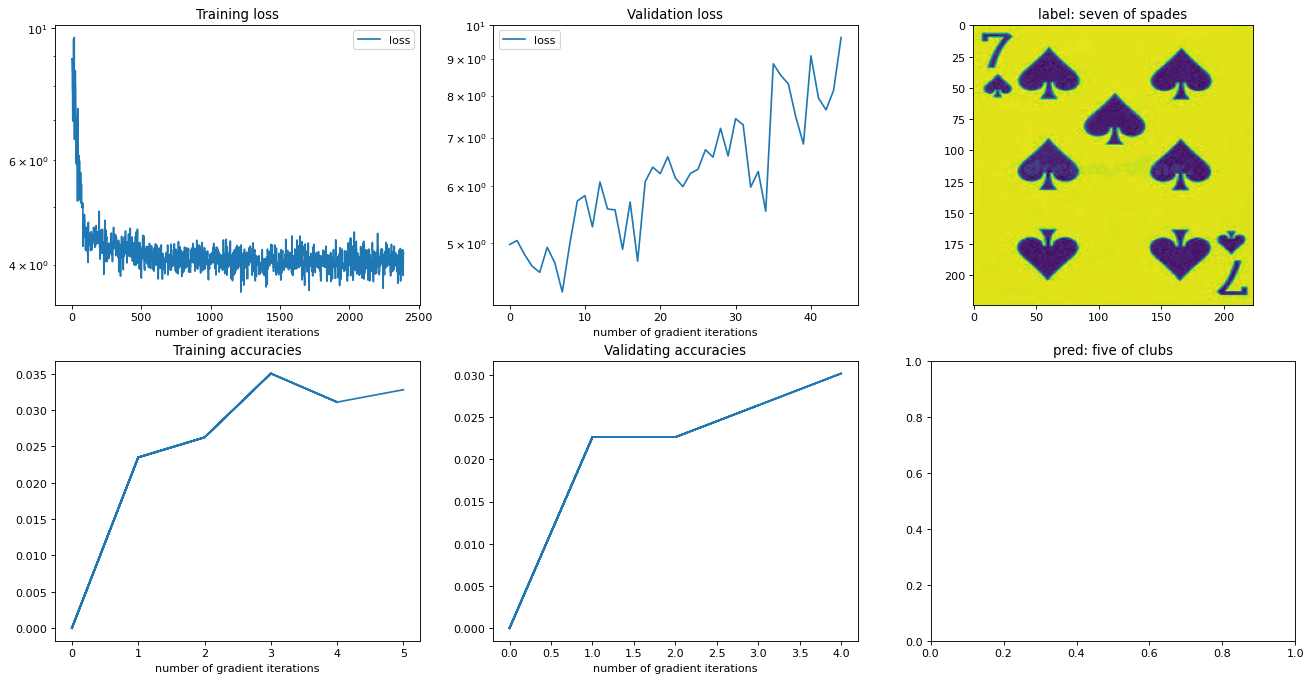

Training epoch 5, iteration 0 of 239 (0 %), loss=4.18716, train accuracy=3.28% 


In [4]:
%matplotlib inline
fig = plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(2,3)

t_total = time.time()
epochs = 750
patience = 100
bad_counter = 0
best = epochs + 1
best_epoch = 0
train_losses = []
train_accs = [0]
val_losses = []
val_accs = [0]
for epoch in range(epochs):
    train_iter = iter(train_loader)
    t = time.time()
    model.train()
    train_count = 0
    train_correct = 0
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        B,_,_,_ = batch_gpu['image'].shape
        adjs = [adj.detach().clone() for i in range(B)]
        ADJ = torch.block_diag(*adjs)
        ADJ = ADJ.to("cuda")

        pred = model(batch_gpu['image'], ADJ)
        loss_train = nn.NLLLoss()(pred, batch_gpu['label'])
        train_losses.append(loss_train.item()) 
        loss_train.backward()
        optimizer.step()

        train_count += B
        train_correct += (pred.cpu().argmax(dim=1) == batch_cpu['label']).sum()
        train_losses.append(loss_train.item())
        #try:
        if i%50==0:
            axes[0,0].cla()

            # plot the training error on a log plot
            axes[0,0].plot(train_losses, label='loss')
            axes[0,0].set_yscale('log')
            axes[0,0].set_title('Training loss')
            axes[0,0].set_xlabel('number of gradient iterations')
            axes[0,0].legend()

            #plot accuracy
            axes[1,0].plot(train_accs, label='accuracy', color='#1f77b4')
            axes[1,0].set_title('Training accuracies')
            axes[1,0].set_xlabel('number of gradient iterations')

            # clear output window and diplay updated figure
            axes[0,2].imshow(batch_cpu['image'][0][0])
            axes[0,2].set_title("label: " + str(classes[batch_cpu['label'][0]]))
            axes[1,2].set_title("pred: " + str(classes[pred.argmax(dim=1)[0]]))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.5f}, train accuracy={:0.2f}% "
                  .format(epoch, i, len(train_loader), 100*i//len(train_loader), train_losses[-1], 100*train_accs[-1]))
        #except Exception as e: 
        #    print(e)
    train_accs.append(train_correct / train_count)
    val_iter = iter(valid_loader)
    model.eval()
    val_count = 0
    val_correct = 0
    for i in range(len(valid_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        B,_,_,_ = batch_gpu['image'].shape
        adjs = [adj.detach().clone() for i in range(B)]
        ADJ = torch.block_diag(*adjs)
        ADJ = ADJ.to("cuda").detach()
        pred = model(batch_gpu['image'], ADJ)
        loss_val = nn.NLLLoss()(pred, batch_gpu['label']) 
        
        val_count += B
        val_correct += (pred.cpu().argmax(dim=1) == batch_cpu['label']).sum()
        val_losses.append(loss_val.item())
        #Todo: implement an accuracy function
        if i%2==0:
            axes[0,1].cla()

            # plot the validation error on a log plot
            axes[0,1].plot(val_losses, label='loss')
            axes[0,1].set_yscale('log')
            axes[0,1].set_title('Validation loss')
            axes[0,1].set_xlabel('number of gradient iterations')
            axes[0,1].legend()

            axes[1,1].plot(val_accs, label='accuracy', color='#1f77b4')
            axes[1,1].set_title('Validating accuracies')
            axes[1,1].set_xlabel('number of gradient iterations')

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.5f}, validation accuracy={:0.2f}%"
                  .format(epoch, i, len(valid_loader), 100*i//len(valid_loader), val_losses[-1], 100*val_accs[-1]))
    
    val_accs.append(val_correct / val_count)
    torch.save(model.state_dict(), '{}.pkl'.format(epoch))   
    if train_losses[-1] < best:
        best = train_losses[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == patience:
        break
    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

    

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)
 

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

# Testing

In [ ]:
import csv

with open('train_loss.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(train_losses)
with open('train_accs.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(train_accs)
with open('val_loss.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(val_losses)
with open('val_accs.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(val_accs)